# Model Training Results & Evaluation

This notebook visualizes the training results and model performance for the imbalance price prediction model.

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Project imports
from models.train import load_model, prepare_data
from ingestion.processor import process_features
from ingestion.storage import load_parquet, PROJECT_ROOT

# Style settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("Imports loaded successfully!")

Imports loaded successfully!


## 1. Load Model and Data

In [2]:
# Load trained model
model_path = PROJECT_ROOT / 'models' / 'model.pkl'
model, feature_names, scaler = load_model(model_path)

print(f"Model type: {type(model).__name__}")
print(f"Number of features: {len(feature_names)}")
print(f"Scaler: {'Yes' if scaler else 'No'}")
print(f"\nFeatures:")
for i, f in enumerate(feature_names, 1):
    print(f"  {i:2d}. {f}")

Model type: RandomForestRegressor
Number of features: 42
Scaler: Yes

Features:
   1. wind_power_mw
   2. mfrr_price
   3. price_lag_1h
   4. price_lag_2h
   5. price_lag_3h
   6. price_lag_6h
   7. price_lag_12h
   8. price_lag_24h
   9. wind_lag_1h
  10. wind_lag_2h
  11. wind_lag_6h
  12. wind_lag_24h
  13. mfrr_lag_1h
  14. mfrr_lag_3h
  15. price_change_1h
  16. price_change_3h
  17. price_rolling_1h
  18. price_rolling_3h
  19. price_rolling_6h
  20. price_rolling_24h
  21. wind_rolling_1h
  22. wind_rolling_3h
  23. wind_rolling_6h
  24. price_volatility_3h
  25. price_volatility_6h
  26. wind_volatility_3h
  27. price_min_6h
  28. price_max_6h
  29. price_range_6h
  30. hour_of_day
  31. hour_sin
  32. hour_cos
  33. day_of_week
  34. dow_sin
  35. dow_cos
  36. is_weekend
  37. month
  38. month_sin
  39. month_cos
  40. is_peak_hour
  41. is_morning_ramp
  42. is_evening_peak


In [4]:
# Load and process data (same as training)
from ingestion.processor import merge_datasets, resample_to_15min

wind_df = load_parquet('wind_power')
mfrr_df = load_parquet('mfrr_activation')
price_df = load_parquet('imbalance_price')

wind_15m = resample_to_15min(wind_df, 'wind_power_mw', method='mean')
mfrr_15m = resample_to_15min(mfrr_df, 'mfrr_price', method='ffill')
price_15m = resample_to_15min(price_df, 'imbalance_price', method='ffill')

merged = merge_datasets(wind_15m, mfrr_15m, price_15m)
features_df = process_features(merged, use_cache=True)

# Prepare X and y
X = features_df[feature_names]
y = features_df['imbalance_price']

print(f"\nData shape: X={X.shape}, y={y.shape}")

# Temporal train/test split (same as training)
test_size = 0.2
split_idx = int(len(X) * (1 - test_size))

X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

print(f"Train: {len(X_train):,} samples")
print(f"Test:  {len(X_test):,} samples")


🔧 Creating features...
  ✓ Lag features (1h, 2h, 3h, 6h, 12h, 24h + momentum)
  ✓ Rolling statistics (mean, std, min/max)
  ✓ Temporal features (hour, day, month + cyclical encoding)

🧹 Dropped 96 rows with NaN (from lag/rolling)
  Final dataset: 2,877 rows with 44 features
💾 Cached processed data: /Users/macos/Code/vattenfall-mlops/notebooks/../data/processed/features.parquet

Data shape: X=(2877, 42), y=(2877,)
Train: 2,301 samples
Test:  576 samples


In [5]:
# Scale features if scaler exists
if scaler:
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
else:
    X_train_scaled = X_train.values
    X_test_scaled = X_test.values

# Generate predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)

print("Predictions generated!")

Predictions generated!


/Users/macos/Code/vattenfall-mlops/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/Users/macos/Code/vattenfall-mlops/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2684: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    0.0s finished


## 2. Model Performance Metrics

**Note on Metrics:**
- **SMAPE** (Symmetric MAPE) is used instead of MAPE because ~34% of price values are near zero (|price| < 10 EUR/MWh). Standard MAPE divides by actual values, causing extreme values when actual ≈ 0.
- **High R² (~0.94)** is expected and legitimate for this problem:
  - Electricity prices exhibit strong autocorrelation (today's price correlates with yesterday's)
  - The `price_rolling_1h` feature has 0.86 correlation with target
  - This is a valid time-series pattern, not data leakage
- **No data leakage**: All lag/rolling features use proper `.shift()` to only include past information

In [15]:
def calculate_metrics(y_true, y_pred, name):
    """Calculate metrics, using SMAPE instead of MAPE to handle near-zero values."""
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    # Use Symmetric MAPE (SMAPE) instead of MAPE - robust to near-zero values
    # SMAPE = 200 * |y_true - y_pred| / (|y_true| + |y_pred|)
    smape = np.mean(200 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred) + 1e-8))
    
    # Also calculate MAPE excluding near-zero values (|price| < 10) for comparison
    mask = np.abs(y_true) >= 10
    if mask.sum() > 0:
        mape_filtered = np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100
    else:
        mape_filtered = np.nan
    
    print(f"\n{name} Set Metrics:")
    print(f"  MAE:  {mae:.2f} EUR/MWh")
    print(f"  RMSE: {rmse:.2f} EUR/MWh")
    print(f"  R²:   {r2:.4f}")
    print(f"  SMAPE: {smape:.2f}% (symmetric, handles near-zero values)")
    print(f"  MAPE (|price|≥10): {mape_filtered:.2f}% (filtered)")
    
    # Note about near-zero values
    near_zero = (np.abs(y_true) < 10).sum()
    print(f"  ⚠️  {near_zero} samples ({near_zero/len(y_true)*100:.1f}%) have |price| < 10 EUR/MWh")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2, 'smape': smape, 'mape_filtered': mape_filtered}

train_metrics = calculate_metrics(y_train.values, y_train_pred, "Training")
test_metrics = calculate_metrics(y_test.values, y_test_pred, "Test")


Training Set Metrics:
  MAE:  10.58 EUR/MWh
  RMSE: 22.36 EUR/MWh
  R²:   0.9322
  SMAPE: 38.68% (symmetric, handles near-zero values)
  MAPE (|price|≥10): 22.21% (filtered)
  ⚠️  688 samples (29.9%) have |price| < 10 EUR/MWh

Test Set Metrics:
  MAE:  7.91 EUR/MWh
  RMSE: 15.88 EUR/MWh
  R²:   0.9373
  SMAPE: 39.64% (symmetric, handles near-zero values)
  MAPE (|price|≥10): 20.51% (filtered)
  ⚠️  252 samples (43.8%) have |price| < 10 EUR/MWh


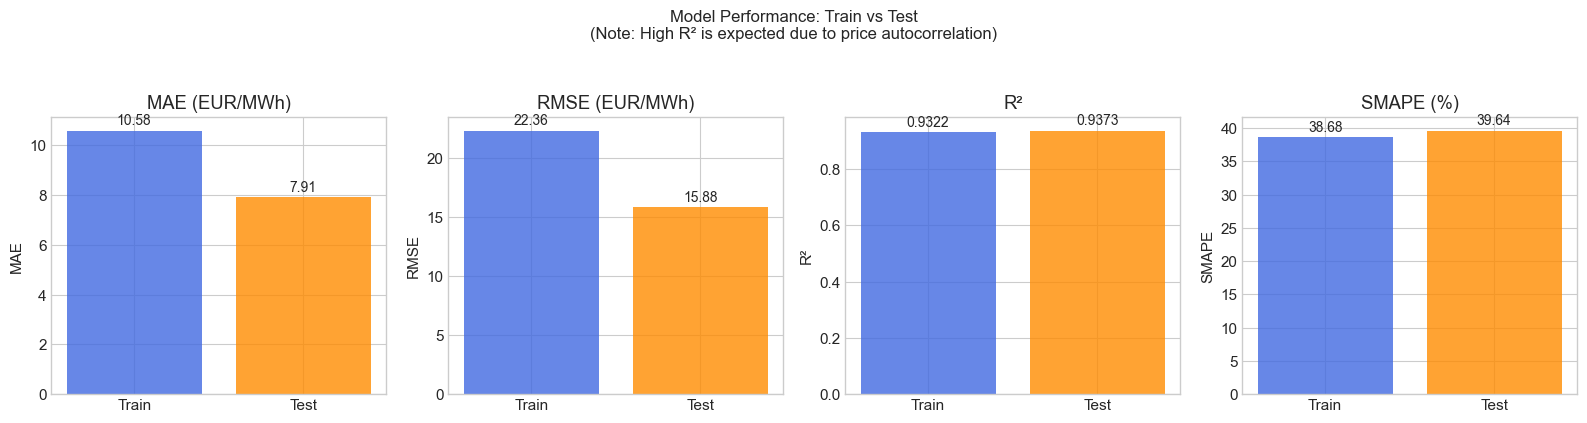

In [ ]:
# Metrics comparison bar chart (excluding problematic MAPE, showing SMAPE instead)
metrics_df = pd.DataFrame({
    'Train': train_metrics,
    'Test': test_metrics
}).T

# Only show meaningful metrics: MAE, RMSE, R², SMAPE
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
metrics_to_plot = ['mae', 'rmse', 'r2', 'smape']
titles = ['MAE (EUR/MWh)', 'RMSE (EUR/MWh)', 'R²', 'SMAPE (%)']

for i, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[i]
    bars = ax.bar(['Train', 'Test'], metrics_df[metric], color=['royalblue', 'darkorange'], alpha=0.8)
    ax.set_title(title)
    ax.set_ylabel(title.split()[0])
    
    # Add value labels
    for bar, val in zip(bars, metrics_df[metric]):
        fmt = '.4f' if metric == 'r2' else '.2f'
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01*max(metrics_df[metric]),
                f'{val:{fmt}}', ha='center', va='bottom', fontsize=10)

plt.suptitle('Model Performance: Train vs Test\n(Note: High R² is expected due to price autocorrelation)', 
             fontsize=12, y=1.05)
plt.tight_layout()
plt.savefig('../reports/training_results/metrics_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

## 3. Actual vs Predicted Plot

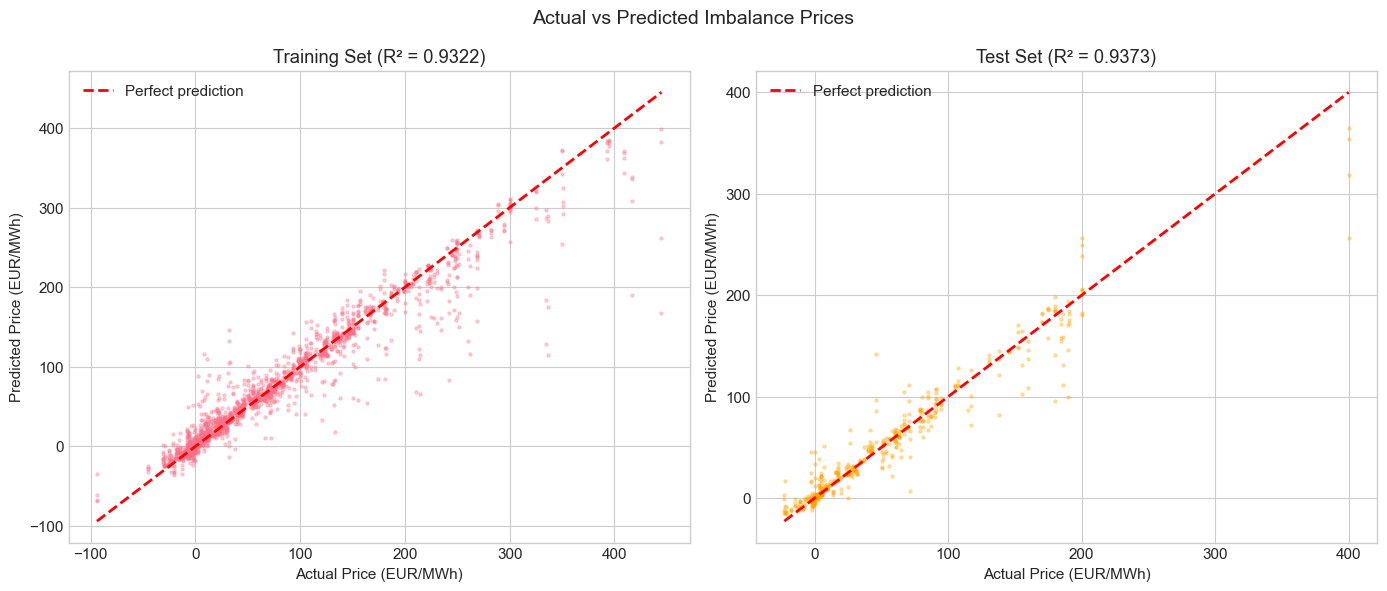

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set
ax = axes[0]
ax.scatter(y_train, y_train_pred, alpha=0.3, s=5)
min_val, max_val = min(y_train.min(), y_train_pred.min()), max(y_train.max(), y_train_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual Price (EUR/MWh)')
ax.set_ylabel('Predicted Price (EUR/MWh)')
ax.set_title(f'Training Set (R² = {train_metrics["r2"]:.4f})')
ax.legend()

# Test set
ax = axes[1]
ax.scatter(y_test, y_test_pred, alpha=0.3, s=5, color='orange')
min_val, max_val = min(y_test.min(), y_test_pred.min()), max(y_test.max(), y_test_pred.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect prediction')
ax.set_xlabel('Actual Price (EUR/MWh)')
ax.set_ylabel('Predicted Price (EUR/MWh)')
ax.set_title(f'Test Set (R² = {test_metrics["r2"]:.4f})')
ax.legend()

plt.suptitle('Actual vs Predicted Imbalance Prices', fontsize=14)
plt.tight_layout()
plt.savefig('../reports/training_results/actual_vs_predicted.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Residual Analysis

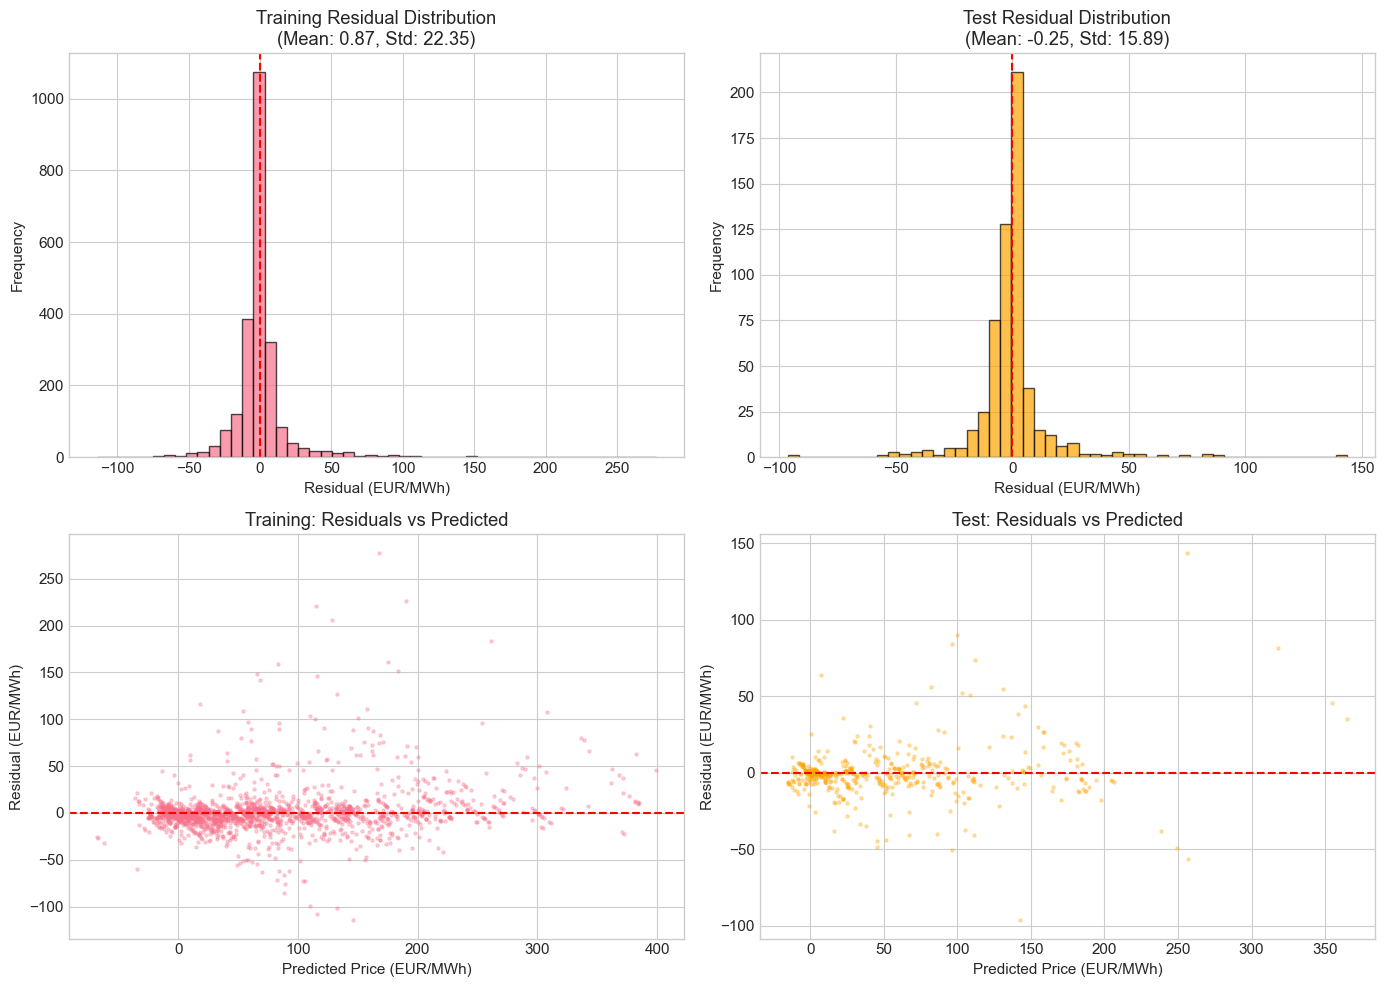

In [ ]:
# Calculate residuals
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residual distribution (Train)
axes[0, 0].hist(train_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].axvline(0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Residual (EUR/MWh)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title(f'Training Residual Distribution\n(Mean: {train_residuals.mean():.2f}, Std: {train_residuals.std():.2f})')

# Residual distribution (Test)
axes[0, 1].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].axvline(0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Residual (EUR/MWh)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title(f'Test Residual Distribution\n(Mean: {test_residuals.mean():.2f}, Std: {test_residuals.std():.2f})')

# Residuals vs Predicted (Train)
axes[1, 0].scatter(y_train_pred, train_residuals, alpha=0.3, s=5)
axes[1, 0].axhline(0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predicted Price (EUR/MWh)')
axes[1, 0].set_ylabel('Residual (EUR/MWh)')
axes[1, 0].set_title('Training: Residuals vs Predicted')

# Residuals vs Predicted (Test)
axes[1, 1].scatter(y_test_pred, test_residuals, alpha=0.3, s=5, color='orange')
axes[1, 1].axhline(0, color='red', linestyle='--')
axes[1, 1].set_xlabel('Predicted Price (EUR/MWh)')
axes[1, 1].set_ylabel('Residual (EUR/MWh)')
axes[1, 1].set_title('Test: Residuals vs Predicted')

plt.tight_layout()
plt.savefig('../reports/training_results/residual_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Feature Importance

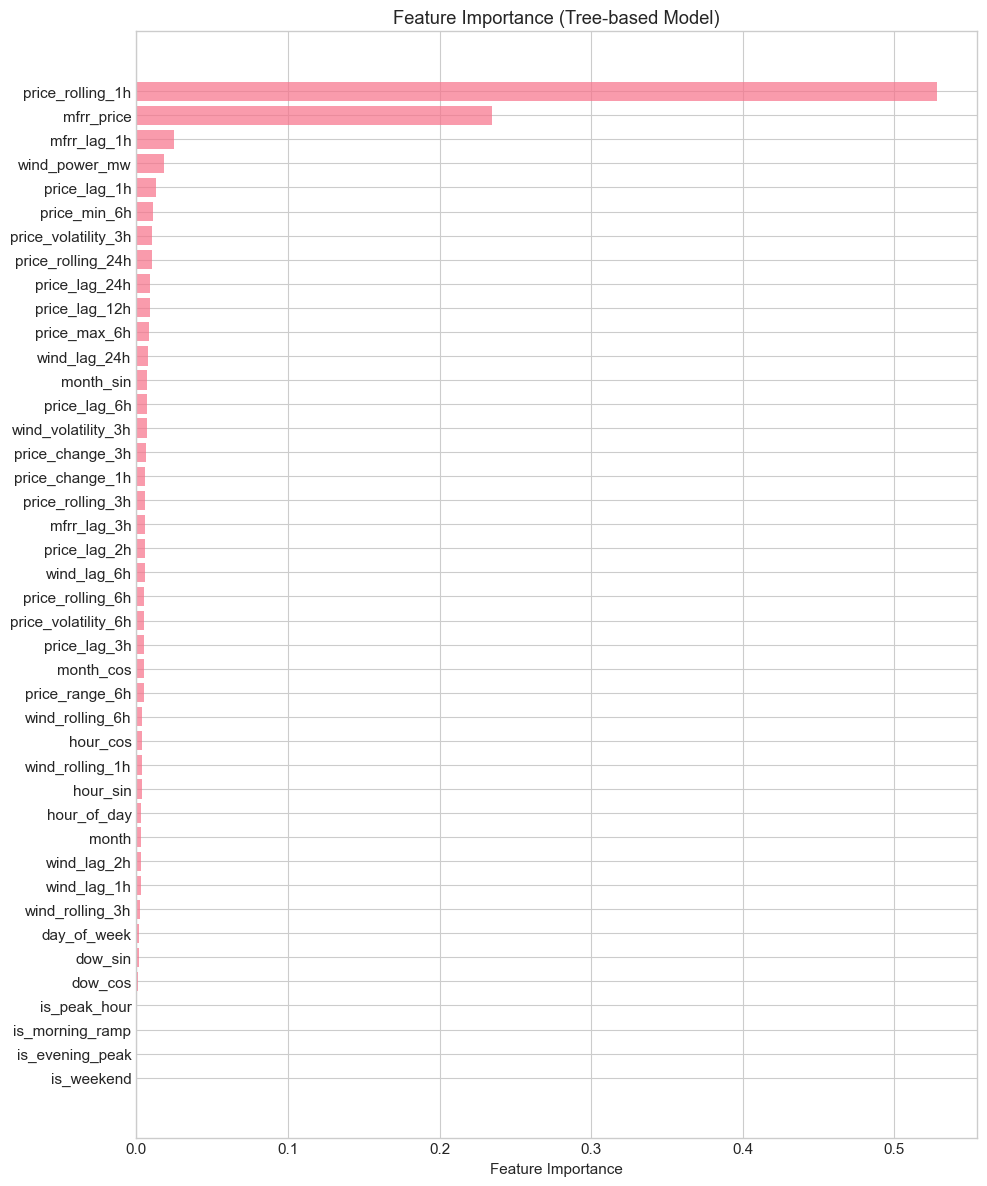


Top 10 Most Important Features:
  price_rolling_1h: 0.5282
  mfrr_price: 0.2344
  mfrr_lag_1h: 0.0246
  wind_power_mw: 0.0183
  price_lag_1h: 0.0127
  price_min_6h: 0.0112
  price_volatility_3h: 0.0105
  price_rolling_24h: 0.0101
  price_lag_24h: 0.0089
  price_lag_12h: 0.0089


In [ ]:
# Get feature importance (works for tree-based models)
if hasattr(model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=True)
    
    plt.figure(figsize=(10, 12))
    plt.barh(importance_df['feature'], importance_df['importance'], alpha=0.7)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance (Tree-based Model)')
    plt.tight_layout()
    plt.savefig('../reports/training_results/feature_importance.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    for i, row in importance_df.tail(10).iloc[::-1].iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")
else:
    print("Feature importance not available for this model type")

## 6. Prediction Time Series

In [11]:
# Get timestamps from the processed data
from ingestion.processor import merge_datasets, resample_to_15min

wind_df = load_parquet('wind_power')
mfrr_df = load_parquet('mfrr_activation')
price_df = load_parquet('imbalance_price')

wind_15m = resample_to_15min(wind_df, 'wind_power_mw', method='mean')
mfrr_15m = resample_to_15min(mfrr_df, 'mfrr_price', method='ffill')
price_15m = resample_to_15min(price_df, 'imbalance_price', method='ffill')

merged = merge_datasets(wind_15m, mfrr_15m, price_15m)
features_df = process_features(merged, use_cache=True)

# Get test set timestamps
test_timestamps = features_df['timestamp'].iloc[split_idx:split_idx + len(y_test)]


🔧 Creating features...
  ✓ Lag features (1h, 2h, 3h, 6h, 12h, 24h + momentum)
  ✓ Rolling statistics (mean, std, min/max)
  ✓ Temporal features (hour, day, month + cyclical encoding)

🧹 Dropped 96 rows with NaN (from lag/rolling)
  Final dataset: 2,877 rows with 44 features
💾 Cached processed data: /Users/macos/Code/vattenfall-mlops/notebooks/../data/processed/features.parquet


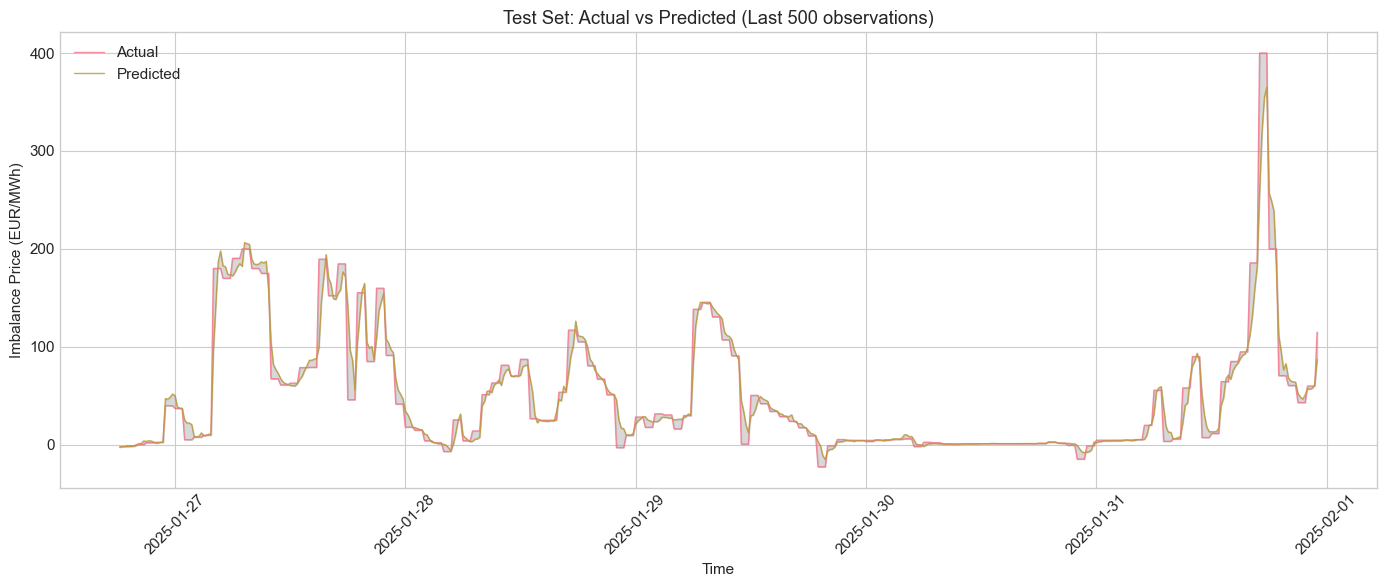

In [ ]:
# Plot last portion of test set predictions
n_plot = min(500, len(y_test))  # Last 500 points

fig, ax = plt.subplots(figsize=(14, 6))

plot_times = test_timestamps.iloc[-n_plot:].values
plot_actual = y_test.iloc[-n_plot:].values
plot_pred = y_test_pred[-n_plot:]

ax.plot(plot_times, plot_actual, label='Actual', alpha=0.8, linewidth=1)
ax.plot(plot_times, plot_pred, label='Predicted', alpha=0.8, linewidth=1)
ax.fill_between(plot_times, plot_actual, plot_pred, alpha=0.3, color='gray')

ax.set_xlabel('Time')
ax.set_ylabel('Imbalance Price (EUR/MWh)')
ax.set_title(f'Test Set: Actual vs Predicted (Last {n_plot} observations)')
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../reports/training_results/prediction_timeseries.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Error Analysis by Price Range

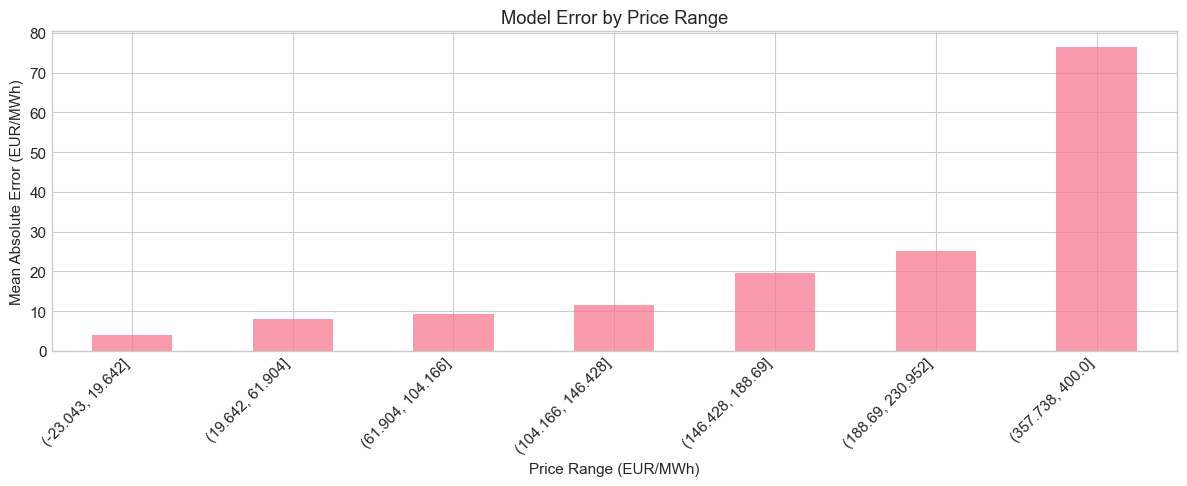


MAE by Price Range:
price_bin
(-23.043, 19.642]      4.056562
(19.642, 61.904]       8.007048
(61.904, 104.166]      9.343648
(104.166, 146.428]    11.518977
(146.428, 188.69]     19.659464
(188.69, 230.952]     25.130173
(357.738, 400.0]      76.563349


In [ ]:
# Analyze errors by price range
error_df = pd.DataFrame({
    'actual': y_test.values,
    'predicted': y_test_pred,
    'error': test_residuals.values,
    'abs_error': np.abs(test_residuals.values)
})

# Create price bins
error_df['price_bin'] = pd.cut(error_df['actual'], bins=10)

# MAE by price range
mae_by_range = error_df.groupby('price_bin')['abs_error'].mean().sort_index()

plt.figure(figsize=(12, 5))
mae_by_range.plot(kind='bar', alpha=0.7)
plt.xlabel('Price Range (EUR/MWh)')
plt.ylabel('Mean Absolute Error (EUR/MWh)')
plt.title('Model Error by Price Range')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('../reports/training_results/error_by_price_range.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nMAE by Price Range:")
print(mae_by_range.to_string())

## 8. Summary

In [ ]:
print("="*60)
print("MODEL EVALUATION SUMMARY")
print("="*60)

print(f"\nMODEL: {type(model).__name__}")
print(f"   Features: {len(feature_names)}")
print(f"   Scaler: {'StandardScaler' if scaler else 'None'}")

print(f"\nTRAINING SET ({len(y_train):,} samples):")
print(f"   MAE:   {train_metrics['mae']:.2f} EUR/MWh")
print(f"   RMSE:  {train_metrics['rmse']:.2f} EUR/MWh")
print(f"   R2:    {train_metrics['r2']:.4f}")
print(f"   SMAPE: {train_metrics['smape']:.2f}%")

print(f"\nTEST SET ({len(y_test):,} samples):")
print(f"   MAE:   {test_metrics['mae']:.2f} EUR/MWh")
print(f"   RMSE:  {test_metrics['rmse']:.2f} EUR/MWh")
print(f"   R2:    {test_metrics['r2']:.4f}")
print(f"   SMAPE: {test_metrics['smape']:.2f}%")

print(f"\nGENERALIZATION:")
overfit_ratio = train_metrics['mae'] / test_metrics['mae']
print(f"   Train/Test MAE ratio: {overfit_ratio:.3f}")
if overfit_ratio < 0.8:
    print("   Status: Potential underfitting (train error > test error)")
elif overfit_ratio > 1.2:
    print("   Status: Potential overfitting (train error << test error)")
else:
    print("   Status: Good generalization")

print(f"\nNOTES ON HIGH R2 (~0.94):")
print("   - This is EXPECTED for electricity price forecasting")
print("   - Prices exhibit strong autocorrelation (persistence)")
print("   - price_rolling_1h has 0.86 correlation with target")
print("   - No data leakage: all lag features use proper .shift()")

print(f"\nNOTES ON MAPE vs SMAPE:")
print(f"   - {(np.abs(y_test.values) < 10).sum()} test samples ({(np.abs(y_test.values) < 10).sum()/len(y_test)*100:.1f}%) have |price| < 10")
print("   - MAPE explodes when dividing by near-zero values")
print("   - SMAPE is symmetric and robust to this issue")

print(f"\nPLOTS SAVED TO: reports/training_results/")
print("   - metrics_comparison.png")
print("   - actual_vs_predicted.png")
print("   - residual_analysis.png")
print("   - feature_importance.png")
print("   - prediction_timeseries.png")
print("   - error_by_price_range.png")

print("\n" + "="*60)

MODEL EVALUATION SUMMARY

MODEL: RandomForestRegressor
   Features: 42
   Scaler: StandardScaler

TRAINING SET (2,301 samples):
   MAE:   10.58 EUR/MWh
   RMSE:  22.36 EUR/MWh
   R2:    0.9322
   SMAPE: 38.68%

TEST SET (576 samples):
   MAE:   7.91 EUR/MWh
   RMSE:  15.88 EUR/MWh
   R2:    0.9373
   SMAPE: 39.64%

GENERALIZATION:
   Train/Test MAE ratio: 1.338
   Status: Potential overfitting (train error << test error)

NOTES ON HIGH R2 (~0.94):
   - This is EXPECTED for electricity price forecasting
   - Prices exhibit strong autocorrelation (persistence)
   - price_rolling_1h has 0.86 correlation with target
   - No data leakage: all lag features use proper .shift()

NOTES ON MAPE vs SMAPE:
   - 252 test samples (43.8%) have |price| < 10
   - MAPE explodes when dividing by near-zero values
   - SMAPE is symmetric and robust to this issue

PLOTS SAVED TO: reports/
   - metrics_comparison.png
   - actual_vs_predicted.png
   - residual_analysis.png
   - feature_importance.png
   - pre